In [1]:
%run init.ipy

#jax.config.update('jax_platform_name', 'cpu')

from lib import constants
from lib import klatt
from lib import util
import random
from vtr.prior import formant
from lib import timit
from inv import process
from inv import model
from vtr.prior import filter

2023-02-18 15:38:15.043422: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-18 15:38:15.043473: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-18 15:38:15.043478: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
def rand_triple():
    vtr_root = timit.test_set(timit.VTRFORMANTS)
    timit_root = timit.test_set(timit.TIMIT)
    l = list(timit.yield_file_triples(vtr_root, timit_root))
    return random.choice(l)

fb_file, phn_file, wav_file = rand_triple()
fb_file, phn_file, wav_file

(PosixPath('/home/marnix/thesis/py/../data/VTRFormants/TEST/DR6/MCMJ0/SI1094.FB'),
 PosixPath('/home/marnix/thesis/py/../data/TIMIT/TEST/DR6/MCMJ0/SI1094.PHN'),
 PosixPath('/home/marnix/thesis/py/../data/TIMIT/TEST/DR6/MCMJ0/SI1094.WAV'))

[Memory]6.2s, 0.1min    : Loading get_aplawd_training_pairs_subset...
[Memory]41.8s, 0.7min   : Loading run_nested...
[Memory]49.0s, 0.8min   : Loading run_nested...
[Memory]55.9s, 0.9min   : Loading run_nested...
[Memory]62.9s, 1.0min   : Loading run_nested...
NP = 5
Number of data points: 333
Number of model dimensions: 82


({'kernel_name': 'Matern32Kernel',
  'kernel_M': 64,
  'use_oq': True,
  'impose_null_integral': True},
 PoleZeroFilter(3))

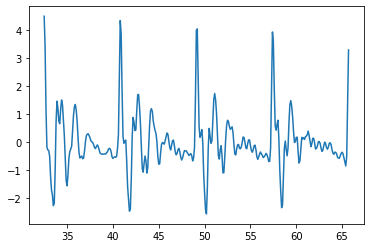

In [3]:
source_config = dict(
    kernel_name = "Matern32Kernel",
    kernel_M = 64,
    use_oq = True,
    impose_null_integral = True
)

vtfilter = filter.PZ(3, numpy_backend=jax.numpy, scipy_backend=jax.scipy)

hyper = process.make_rand_hyper(
    (fb_file, phn_file, wav_file),
    source_config = source_config,
    vtfilter = vtfilter,
    process_data_kwargs=dict(max_NP = 5, prepend=1)
)

hyper['meta']['noiseless_estimates'] = True

plot(hyper['data']['t'], hyper['data']['d'])
print("NP =", hyper['data']['NP'])
print("Number of data points:", len(hyper['data']['d']))
print("Number of model dimensions:", model.ndim(hyper))

display(klatt.play(hyper['data']['t'], hyper['data']['d']))

hyper['source'], hyper['filter']

## Try VI with jax_advi

In general gradients break down close to the bounds of $\theta$.

Out of memory problems can be mitigated by lowering the number of samples used in ADVI ($M$).
The higher $M$, the more stable to optimization, but the longer runtime and memory requirements.

In [17]:
import jax_advi
import jax.scipy

In [18]:
ndim = model.ndim(hyper)
print(ndim)
theta_bijector = model.theta_trajectory_bijector(hyper)

def logabsdet_delw_deltheta(w):
    return -theta_bijector.forward_log_det_jacobian(w)

def loglike(w):
    """Return L(theta(w)) where a priori w ~ N(0, I)"""
    theta = theta_bijector.forward(w)
    logcorrection = logabsdet_delw_deltheta(w)
    loglikelihood = model.full_likelihood(theta, hyper)
    return loglikelihood + logcorrection

def logprior(w):
    return jnp.sum(jax.scipy.stats.norm.logpdf(w))

def minus_inf_if_nan(x):
    return jax.lax.cond(jnp.isnan(x), lambda: -jnp.inf, lambda: x)

def logjoint(w):
    lj = loglike(w) + logprior(w)
    return minus_inf_if_nan(lj)

# Test our likelihood and joint functions: OK
prior = model.theta_trajectory_prior(hyper)
theta = prior.sample(seed=jaxkey())

l1 = model.full_likelihood(theta, hyper) + prior.log_prob(theta)

#
w = theta_bijector.inverse(theta)
l2 = logjoint(w)

#
l1, l2

82
[Memory]2011.6s, 33.5min: Loading posterior_of_fitted_lf_values...
[Memory]2011.7s, 33.5min: Loading run_nested...
[Memory]2011.7s, 33.5min: Loading posterior_of_fitted_TFB_values...
[Memory]2011.7s, 33.5min: Loading run_nested...
[Memory]2011.8s, 33.5min: Loading posterior_of_fitted_lf_values...
[Memory]2011.8s, 33.5min: Loading run_nested...
[Memory]2011.9s, 33.5min: Loading posterior_of_fitted_TFB_values...
[Memory]2011.9s, 33.5min: Loading run_nested...


(DeviceArray(-396.78807604, dtype=float64),
 DeviceArray(-396.78807604, dtype=float64))

In [19]:
import jax_advi.advi

theta_shapes = {'w': (ndim,)}

# Jitting happens inside
result = jax_advi.advi.optimize_advi_mean_field(
    theta_shapes,
    lambda theta: logprior(theta['w']),
    lambda theta: loglike(theta['w']),
    verbose=True,
    M=15,
    opt_method="L-BFGS-B" # This is faster and seems to be leap succesfully over early local minima
)

6947.8139888672695 15310.110651408739
1206.5855621312364 1786.9912460192193
991.1331905342139 1369.0387450750798
563.4654812482033 528.987757736616
437.1822829876573 262.9455974463462
370.27920201146355 132.21611185455018
335.8453668453933 60.56562923624244
317.95225211458677 53.33159143780731
287.9999517481284 67.00828676133148
224.9835387492877 98.63075153920207
394.9933311673895 1074.1435528973261
137.98178185243484 125.95092555645252
444.21280496901716 1191.3497121626983
66.40967584125434 197.2209547302195
32668.19853644189 143052.7453687626
89.28001793344046 503.0575253041158
14.38315907055894 202.25856636966162
211.82401075071573 612.4255890202023
-5.15276988723881 193.80238999459792
0.23555416975190546 212.09801813871906
-31.283631008931927 157.8454713503144
-44.918460110432775 71.45834014759151
-57.703178816942085 111.88429934890902
-75.72643243255787 134.07378927852017
-72.6174428226178 247.78552195713837
-109.54884723784777 110.16767696840475
-56.425557746257454 616.313956843

0	log L = 119.6185487336395	SNR [dB] = 29.527096850616275
1	log L = 100.5743195112978	SNR [dB] = 29.860874644687776
2	log L = -564.7694131924928	SNR [dB] = 30.45175359451967


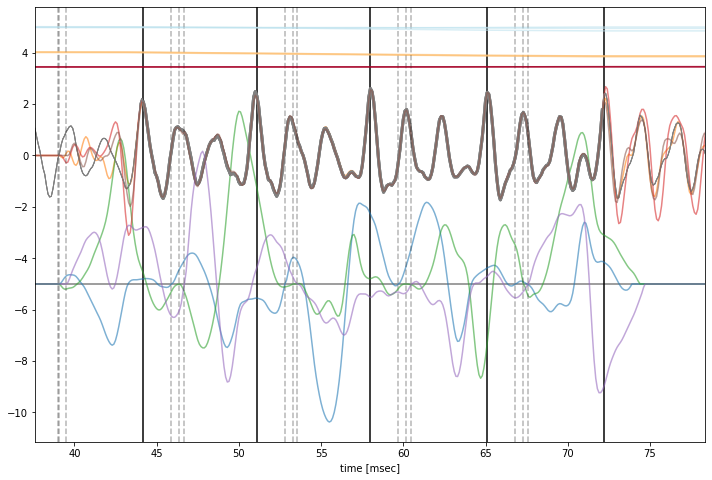

In [20]:
def lstsq(R, y, noise_power):
    D = jnp.eye(R.shape[1])
    Z = noise_power * D + R.T @ R
    L, lower = jax.scipy.linalg.cho_factor(Z, lower=True, check_finite=False)
    b = R.T @ y
    x = jax.scipy.linalg.cho_solve((L, lower), b, check_finite=False)
    return x

def setxlim(f, margin=0.05):
    ts = hyper['data']['fullt'][f != 0.]
    xlim(ts[0]*(1-margin), ts[-1]*(1+margin))

nsamp = 3

w_samples = result['draws']['w'][:nsamp,:]

figsize(12, 8)
axhline(-5, color="grey")

for pest in hyper['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, hyper), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)
    offset = model.get_offset(delta, theta_source, hyper)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper, convolve=True
    )

    f_mean = lstsq(R, hyper['data']['d'], noise_sigma**2)

    hyper2 = process.hyper_fullt(hyper)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(hyper['data']['fullt'], hyper['data']['fulld'], color="grey", label="data", lw=1)
    plot(hyper['data']['t'], hyper['data']['d'], color="grey", label="data", lw=3)
    plot(hyper['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(hyper['data']['fullt'], ft, label="f(t)", alpha=alpha)
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            hyper['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            hyper['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/hyper['filter'].K)
        )

    #display(klatt.play(hyper['data']['t'], hyper['data']['d']))
    #display(klatt.play(hyper['data']['t'], ft))

In [21]:
theta

{'noise_sigma': DeviceArray(0.03002011, dtype=float64),
 'delta': DeviceArray(-2.45907242, dtype=float64),
 'source': DeviceArray([[0.70843336, 0.05791199, 7.15825116, 0.999     ],
              [0.61123143, 0.0502801 , 6.89999912, 0.999     ],
              [0.58995664, 0.04873505, 6.90000177, 0.999     ],
              [0.60122218, 0.04947972, 7.09999949, 0.999     ],
              [0.57845171, 0.04228838, 7.09999954, 0.999     ]],            dtype=float64),
 'filter': DeviceArray([[ 453.28401329, 1020.63255532, 1981.46903831,   20.08831609,
                 58.14455607,   20.00006635],
              [ 450.52361053,  982.82122815, 1978.56649085,   20.08029416,
                 44.62848056,   20.00005177],
              [ 447.7376609 ,  948.43861664, 1979.17815345,   20.07324455,
                 35.90932504,   20.00005193],
              [ 456.05659674,  905.09049158, 1964.74020535,   20.0818598 ,
                 33.82766992,   20.00006189],
              [ 448.12905822,  871.283060

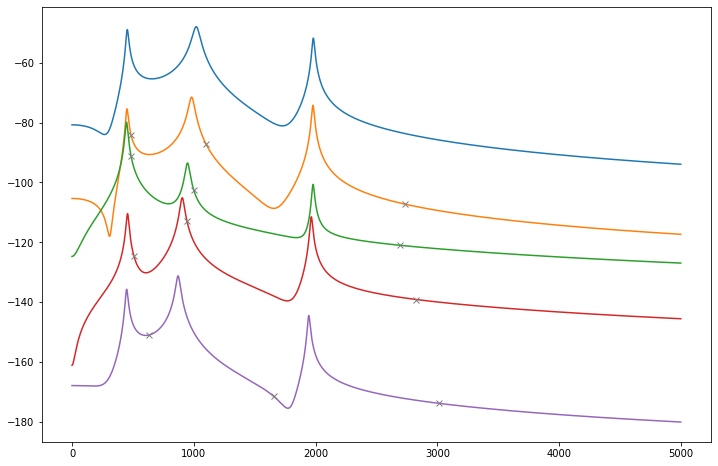

In [22]:
f = constants.spectrum_frequencies()

powers = jax.vmap(hyper['filter'].transfer_function_power_dB, (None, 0, 0, 0))(
    f, theta_filter['x'], theta_filter['y'], theta_filter['g']
)

for i, power in enumerate(powers):
    plot(f, power - i*20)
    
    F = hyper['data']['F_estimate'][i,:]
    estim = np.interp(F, f, power - i*20)
    plot(F, estim, 'x', color="grey")

## Higher $K$